Loading up the specific dependencies for image processing, modeling and inference

In [1]:
import tensorflow as tf
import tensorflow_hub as tf_hub
from PIL import Image 
import matplotlib.pyplot as plt 
import numpy as np
print('TF Version:', tf.__version__)
print('TF Hub Version:', tf_hub.__version__)

TF Version: 2.9.2
TF Hub Version: 0.12.0


In [2]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
!wget https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt

--2022-10-29 13:56:08--  https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10484 (10K) [text/plain]
Saving to: ‘ImageNetLabels.txt’

ImageNetLabels.txt  100%[===================>]  10.24K  --.-KB/s    in 0s      

2022-10-29 13:56:08 (106 MB/s) - ‘ImageNetLabels.txt’ saved [10484/10484]

--2022-10-29 13:56:09--  https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 522999 (511K) [text/plain]
Saving to: ‘imagenet21k_wordn

In [3]:
data1k = []
with open('ImageNetLabels.txt', 'r') as f:
     data1k = f.readlines()
  
data21k = []
with open('imagenet21k_wordnet_lemmas.txt', 'r') as f:
     data21k = f.readlines()
  
imagenet1k_mapping = {i: value.strip('\n') 
                           for i, value in enumerate(data1k)}
imagenet21k_mapping = {i: value.strip('\n') 
                           for i, value in enumerate(data21k)}

In [4]:
print('ImageNet 1K (ResNet-50) Total Classes:', 
       len(list(imagenet1k_mapping.items())))
print('Sample:', list(imagenet1k_mapping.items())[:5])
  
print('\nImageNet 21K (BiT ResNet-152 4x)Total Classes:', 
       len(list(imagenet21k_mapping.items())))
print('Sample:', list(imagenet21k_mapping.items())[:5])

ImageNet 1K (ResNet-50) Total Classes: 1001
Sample: [(0, 'background'), (1, 'tench'), (2, 'goldfish'), (3, 'great white shark'), (4, 'tiger shark')]

ImageNet 21K (BiT ResNet-152 4x)Total Classes: 21843
Sample: [(0, 'organism, being'), (1, 'benthos'), (2, 'heterotroph'), (3, 'cell'), (4, 'person, individual, someone, somebody, mortal, soul')]


We would load up the two pre-trained models

In [5]:
resnet_model_url = "https://tfhub.dev/tensorflow/resnet_50/classification/1"
resnet_50 = tf_hub.KerasLayer(resnet_model_url)
  
bit_model_url = "https://tfhub.dev/google/bit/m-r152x4/imagenet21k_classification/1"
bit_r152x4 = tf_hub.KerasLayer(bit_model_url)

The preprocess_image(…) function helps us in pre-processing, shaping and scaling the input image pixel values between the range of 0–1.
The visualize_predictions function takes in the pre-trained model, the class label mappings, the model type and the input image as inputs to visualise the top-5 predictions as a bar chart.

In [6]:
#A Get class probabilities directly for pre-trained ResNet-50
#B Get logits and then derive class probabilities for pre-trained BiTM-R152x4
#C Get the top 5 class predictions and probabilities

def visualize_predictions(model, image, imagenet_mapping_dict, 
                          model_type='resnet'):
    if model_type =='resnet':    #A 
        probs = model(image)
        probs = tf.reshape(probs, [-1])
    else:    #B
        logits = model(image)
        logits = tf.reshape(logits, [-1])
        probs = tf.nn.softmax(logits)

    top5_imagenet_idxs = np.argsort(probs)[:-6:-1]    #C 
    top5_probs = np.sort(probs)[:-6:-1]    #C
    pred_labels = [imagenet_mapping_dict[i]    #C 
                       for i in top5_imagenet_idxs]
  # more after this

In [7]:
from sklearn import preprocessing

In [8]:
def preprocess_image(image):
    image = np.array(image)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
    return image

In [9]:
def visualize_predictions(model, image, imagenet_mapping_dict, 
                          model_type='resnet'):
    if model_type =='resnet':
        probs = model(image)
        probs = tf.reshape(probs, [-1])
    else:
        logits = model(image)
        logits = tf.reshape(logits, [-1])
        probs = tf.nn.softmax(logits)
    top5_imagenet_idxs = np.argsort(probs)[:-6:-1]
    top5_probs = np.sort(probs)[:-6:-1]
    pred_labels = [imagenet_mapping_dict[i] 
                       for i in top5_imagenet_idxs]

    height = top5_probs
    bars = pred_labels
    y_pos = np.flip(np.arange(len(bars)))
    
    # Create horizontal bars
    plt.barh(y_pos, height, color='skyblue')
    for i, v in zip(y_pos, height):
        plt.text(x=max(0.05, v-0.3), y=i-0.15, 
                s=round(v,3), color='black', size=15)
    
    # Create names on the y-axis
    plt.yticks(y_pos, bars);
    plt.title('Model: '+model_type)

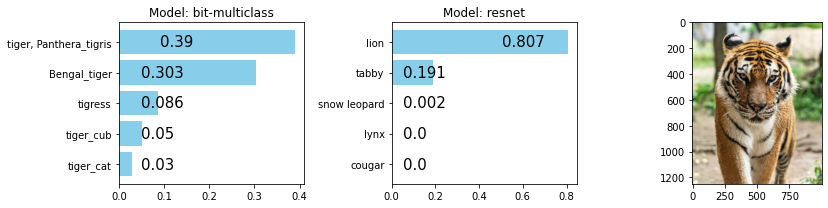

In [10]:
img = Image.open('tiger.jpg').convert("RGB")
pre_img = preprocess_image(img)
plt.figure(figsize=(12, 3))

plt.subplot(1,3,1)
visualize_predictions(model=bit_r152x4, image=pre_img,
                      imagenet_mapping_dict=imagenet21k_mapping,
                      model_type='bit-multiclass')

plt.subplot(1,3,2)
resnet_img = tf.image.resize(pre_img, (224, 224))
visualize_predictions(model=resnet_50, image=resnet_img,
                      imagenet_mapping_dict=imagenet1k_mapping,
                      model_type='resnet')

plt.subplot(1,3,3)
plt.imshow(pre_img[0])
plt.tight_layout()

It looks like both our models performed well, and as expected the BitM model is very specific and more accurate given it has been trained on over 21K classes with very specific animal species and breeds.

The ResNet-50 model has more inconsistencies as compared to the BiTM model with regard to predicting on animals of similar genus but slightly different species